# Analyzing SF birthweight data


In [1]:
#lets import some things
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

## Load data

In [2]:
link_to_file = "https://raw.githubusercontent.com/Center-for-Health-Data-Science/Python_part2/main/data/project_work/birth.csv"

df = pd.read_csv(link_to_file)
df.head()

,case,bwt,gestation,age,height,weight,smoke,ses
0,1,120,284.0,27.0,62.0,100.0,0.0,high
1,2,113,282.0,33.0,64.0,135.0,0.0,low
2,3,128,279.0,28.0,64.0,115.0,1.0,middle
3,4,123,NaN,36.0,69.0,190.0,0.0,middle
4,5,108,282.0,23.0,67.0,125.0,1.0,low


## EDA and data cleaning

### Features present



We have a look at the number of unique elements in each column to determine which of them are numeric and which are categorical.

In [ ]:
df.nunique()

,0
case,1236
bwt,107
gestation,106
age,30
height,19
weight,105
smoke,2
ses,3


In [ ]:
df.shape

(1236, 8)

The dataframe has 1236 rows, as many as there are unique values in the `case` column so it is likely that it is an ID (even if we did not have the description of each feature).

We also see that `smoke` and `ses` only have 2 and 3 different values, respectively. This likely means they are categorical features with respectively 2 and 3 different categories.

The rest of the features we take to be numeric since we can see with the `head()` command that they are not string columns. The `info()` command also confirms this.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236 entries, 0 to 1235
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   case       1236 non-null   int64  
 1   bwt        1236 non-null   int64  
 2   gestation  1223 non-null   float64
 3   age        1234 non-null   float64
 4   height     1214 non-null   float64
 5   weight     1200 non-null   float64
 6   smoke      1226 non-null   float64
 7   ses        1236 non-null   object 
dtypes: float64(5), int64(2), object(1)
memory usage: 77.4+ KB


In [6]:
#remove ID column
df = df.drop(columns = 'case')

In [5]:
numeric_features = ['gestation', 'age', 'height', 'weight']
categorical_features = ['smoke', 'ses']

### Missing data

We have missing data for some features:

In [ ]:
df.isna().sum(axis=0)

,0
bwt,0
gestation,13
age,2
height,22
weight,36
smoke,10
ses,0


`LinearRegression` from scikit learn does not accept missing values so we remove the rows that have them.

In [3]:
df = df.dropna()

### Categorical features Balance

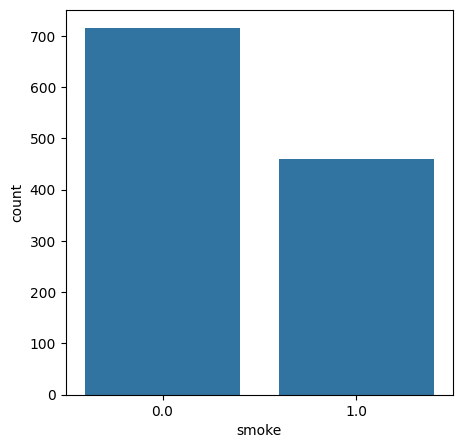

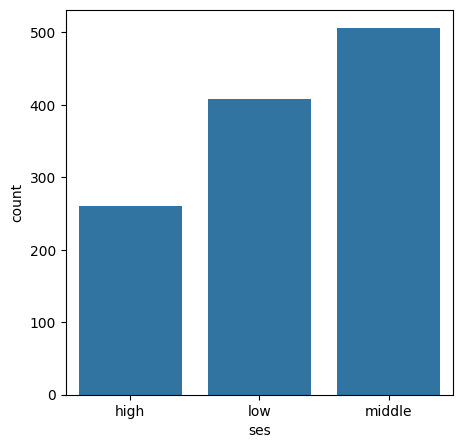

In [7]:
for col in categorical_features:
    plt.figure(figsize=(5,5))
    sns.countplot(df, x = col)

### Summary stats for numeric features



In [8]:
df.loc[:,numeric_features].describe()

,gestation,age,height,weight
count,1174.000000,1174.000000,1174.000000,1174.000000
mean,279.101363,27.228279,64.049404,128.478705
std,16.010305,5.817839,2.526102,20.734282
min,148.000000,15.000000,53.000000,87.000000
25%,272.000000,23.000000,62.000000,114.250000
50%,280.000000,26.000000,64.000000,125.000000
75%,288.000000,31.000000,66.000000,139.000000
max,353.000000,45.000000,72.000000,250.000000


### Distributions and outliers

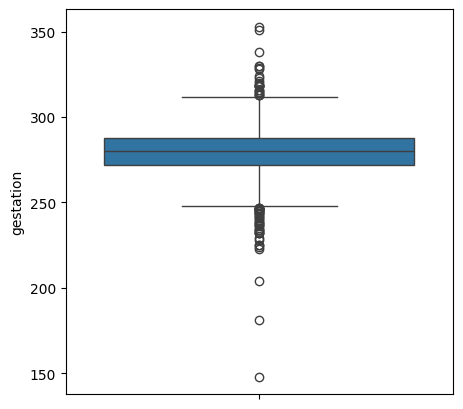

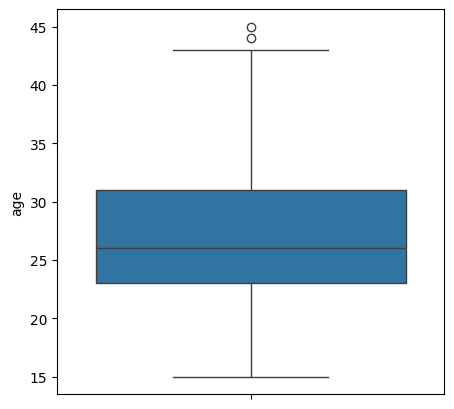

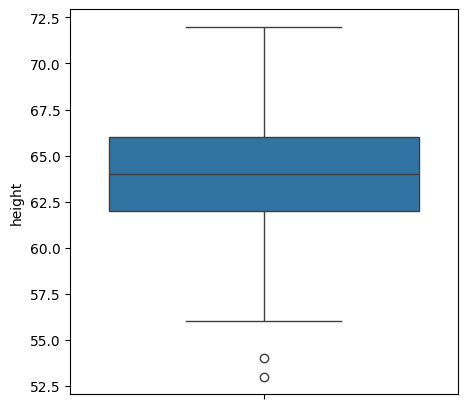

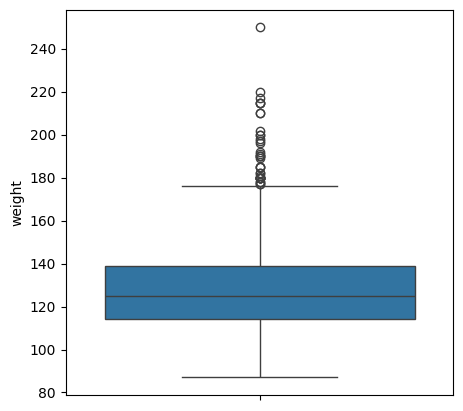

In [9]:
for col in numeric_features:
    plt.figure(figsize=(5,5))
    sns.boxplot(df, y = col)

The categorical features do not appear extremely imbalanced so we will use them like they are.

The distrubtions and range of numeric features look fine for all features except gestation.

It is somewhat doubtful whether someone was really pregnant for 153 days == 50 weeks. Anything past 320 days is unlikely based on data from the [North Carolina Early Pregnancy Study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3777570/) (1982 - 1985). It is not know whether gestation in this dataset is measured from last menstrual period or ovulation. We will omit pregnancies longer than 320 days.

In [10]:
df = df.loc[df['gestation'] <= 320]

### Correlations

In [11]:
corrs = df.loc[:,numeric_features+['bwt']].corr()

<Axes: >

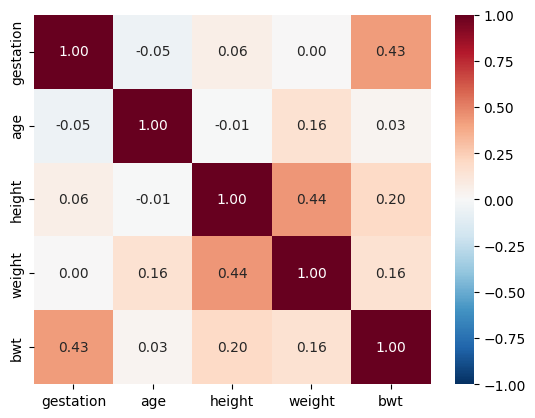

In [ ]:
sns.heatmap(corrs,
            cmap = "RdBu_r",
            center = 0, vmin = -1, vmax = 1,
            annot=True, fmt=".2f")

Birthweight is most strongly correlated with gestation lenght.

Unsurprisingly, mother's height and weight is also correlated.

## Prepare Data for modelling

### Dummy coding

Smoking is binary so we can use it like that. SES has 3 levels so we need dummies.

In [ ]:
dummy_ses = pd.get_dummies(df['ses'], drop_first = True)
dummy_ses.head()

,low,middle
0,False,False
1,True,False
2,False,True
4,True,False
5,False,True


### Scaling of numeric features

Scaling numeric features can help us with the interpretation of the regression coefficients later.

We can use the scikit learn scaler as before.

In [ ]:
#scale the numeric predictors
num_pred = df.loc[:,['gestation', 'age', 'height', 'weight']].to_numpy()

scaling = StandardScaler()
num_pred_scale = scaling.fit_transform(num_pred)
num_pred_scale

array([[ 0.35150439, -0.04296689, -0.80808051, -1.37544549],
       [ 0.22032417,  0.98823853, -0.01798751,  0.32322218],
       [ 0.02355384,  0.12890068, -0.01798751, -0.64744506],
       ...,
       [ 0.81063516,  0.47263582,  0.37705899,  1.05122261],
       [ 0.15473406, -1.07417231,  0.37705899, -0.89011187],
       [ 1.20417582,  1.84757638,  0.37705899,  0.03202201]])

### Combining scaled numeric features with smoking and dummy SES into the feature matrix X

`StandardScaler()` produces a numpy array, which is good because we need our data in that format anyway for scikit learn.

Our array of scaled features has the following shape:

In [ ]:
num_pred_scale.shape

(1164, 4)

And we need to add 3 columns: one binary column for smoking and the two binary dummy columns for socioeconomic status.

We need `reshape` to make the smoking column 2 dimensional:

In [ ]:
smoke_col = df['smoke'].to_numpy().reshape(-1, 1)
smoke_col.shape

(1164, 1)

In [ ]:
dummy_ses = dummy_ses.to_numpy()
dummy_ses.shape

(1164, 2)

Now we can combine them into the feature array X

In [ ]:
X = np.concatenate((num_pred_scale, smoke_col, dummy_ses), axis=1)
X[:10]

array([[ 0.35150439, -0.04296689, -0.80808051, -1.37544549,  0.        ,
         0.        ,  0.        ],
       [ 0.22032417,  0.98823853, -0.01798751,  0.32322218,  0.        ,
         1.        ,  0.        ],
       [ 0.02355384,  0.12890068, -0.01798751, -0.64744506,  1.        ,
         0.        ,  1.        ],
       [ 0.22032417, -0.73043717,  1.16715198, -0.16211144,  1.        ,
         1.        ,  0.        ],
       [ 0.48268461, -0.38670203, -0.80808051, -1.71517902,  0.        ,
         0.        ,  1.        ],
       [-2.27210002,  0.98823853, -0.80808051,  2.41015675,  0.        ,
         1.        ,  0.        ],
       [-2.20650991, -0.73043717,  0.37705899,  0.56588899,  0.        ,
         0.        ,  1.        ],
       [ 0.67945494, -0.38670203, -0.80808051, -0.16211144,  0.        ,
         0.        ,  1.        ],
       [ 1.33535604,  0.47263582,  0.77210548,  0.37175555,  1.        ,
         1.        ,  0.        ],
       [ 0.22032417,  0.8163

In [ ]:
y = df['bwt']

### Split into test and training set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

### PCA

Now that you have extracted and scaled numeric features you can make a PCA of them to investigate the structure of the data.

In [ ]:
from sklearn.decomposition import PCA
PCA_obj = PCA(n_components = 4)
transformed = PCA_obj.fit_transform(num_pred_scale)
pca_df = pd.DataFrame(transformed, columns= ['PC1', 'PC2', 'PC3', 'PC4'])

In [ ]:
#features = ['gestation', 'age', 'height', 'weight']

#rescale PCs
scalePC1 = 2.0/(pca_df['PC1'].max() - pca_df['PC1'].min())
scalePC2 = 2.0/(pca_df['PC2'].max() - pca_df['PC2'].min())
pca_df['PC1_scaled'] = pca_df['PC1'] * scalePC1
pca_df['PC2_scaled'] = pca_df['PC2'] * scalePC2


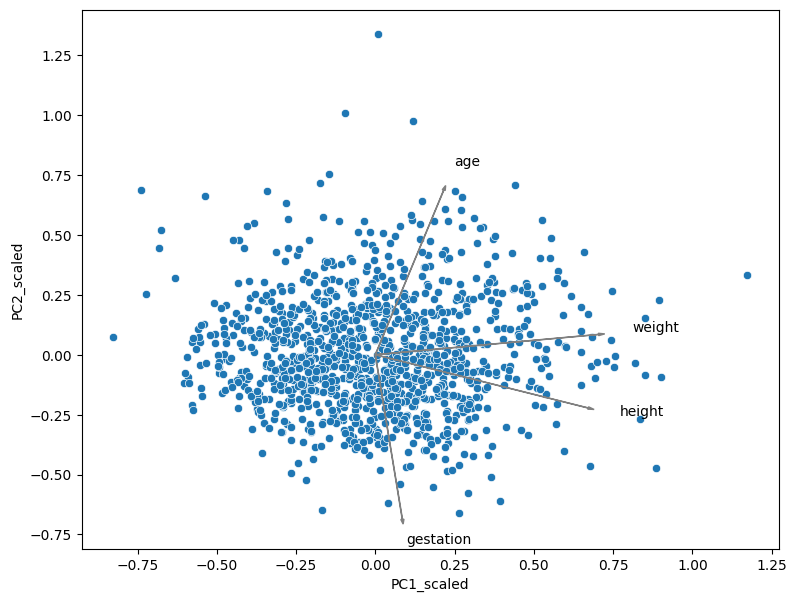

In [ ]:
plt.figure(figsize=(9,7))

#the data projected into PC1 and PC2, colored by outcome
sns.scatterplot(pca_df, x = 'PC1_scaled', y = 'PC2_scaled')

#the eigenvectors
for i, feature in enumerate(numeric_features):
    plt.arrow(0, 0,
              PCA_obj.components_[0, i],
              PCA_obj.components_[1, i],
              head_width=0.01,
              head_length=0.02,
              color="gray")
    plt.text(PCA_obj.components_[0, i] * 1.15,
            PCA_obj.components_[1, i] * 1.15,
            feature, fontsize=10)

There is not much structure in the numeric features.

## Training the model

We initalize a `LinearRegression` object with default parameters and fit to our X and y:

In [ ]:
lin_model = LinearRegression()
lin_model.fit(X_train,y_train)

LinearRegression()

## Model evaluation

The typical way to evaluate regression models is to predict on the held out test set and measure the discrepancy between prediction and the true value with the mean squared error.

Unlike our earlier example data of daily cigarettes and life expectancy, this time X and X_test are already two dimensional so there is no need to reshape.

In [ ]:
X_test.shape

(291, 7)

In [ ]:
y_pred = lin_model.predict(X_test)
y_pred[:10]

array([127.24445735, 124.47429346, 112.55032756, 109.35384331,
       123.55525095, 122.71516705, 137.12942623, 122.34603124,
       115.12722923, 117.51155224])

In [ ]:
mse=mean_squared_error(y_test, y_pred)
mse

257.52040386363876

The mse is large compared to the range of birthweights observed in the dataset, as well as their standard deviation.

In [ ]:
df['bwt'].describe()

,bwt
count,1236.000000
mean,119.576861
std,18.236452
min,55.000000
25%,108.750000
50%,120.000000
75%,131.000000
max,176.000000


## Model interpretation

Let's have a look at the parameters we have estimated:

In [ ]:
lin_model.intercept_

125.59858409877847

This means the average expected birthweight is 125 ounces when all numeric features are at their average and the mother is a non-smoker and in the 'high' socioeconomic status.   

Feature values being not average changes this expected birthweight with the scale of the coefficients:

In [ ]:
lin_model.coef_

array([ 7.65467668,  0.73202576,  2.45670094,  1.07647514, -8.00163512,
       -7.79171234, -1.4487134 ])

For example switching from non-smoker to smoker decreases the mean birthweight estimate by 8 ounces, and the mother being in 'low' socioeconomic status instead of 'high' also decreases it by 7.8 ounces.